In [1]:
import numpy as np
import argparse
import imutils
import time
import cv2
import os
from visualize import *

root = os.getcwd()

In [3]:
labelsPath = os.path.join(root, "yolo_predictor/custom.names")
LABELS = open(labelsPath).read().strip().split("\n")

np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
    dtype="uint8")

# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.join(root, "yolo_predictor/yolov3-custom_9700.weights")
configPath = os.path.join(root, "yolo_predictor/cfg/yolov3-custom.cfg")

# load our YOLO object detector trained on COCO dataset (80 classes)
# and determine only the *output* layer names that we need from YOLO
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

[INFO] loading YOLO from disk...


In [5]:
vs = cv2.VideoCapture('cut.mp4')
writer = None
(W, H) = (None, None)
# try to determine the total number of frames in the video file
try:
    prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
        else cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))
    print("[INFO] {} total frames in video".format(total))
# an error occurred while trying to determine the total
# number of frames in the video file
except:
    print("[INFO] could not determine # of frames in video")
    print("[INFO] no approx. completion time can be provided")
    total = -1

[INFO] 240 total frames in video


2
The Expression is sad
[INFO] single frame took 0.4987 seconds
[INFO] estimated total time to finish: 119.6777


/Users/suraj/Desktop/project/visualize.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes=plt.subplot(1, 3, 1)
/Users/suraj/Desktop/project/visualize.py:77: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, 2)
/Users/suraj/Desktop/project/visualize.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new

1
The Expression is angry
0
The Expression is happy
0
The Expression is happy
1
The Expression is angry
1
The Expression is angry
1
The Expression is angry
1
The Expression is angry
1
The Expression is angry
1
The Expression is angry
1
The Expression is angry
1
The Expression is angry
1
The Expression is angry
1
The Expression is angry
1
The Expression is angry
1
The Expression is angry
1
The Expression is angry
1
The Expression is angry
1
The Expression is angry
1
The Expression is angry
1
The Expression is angry
1
The Expression is angry
1
The Expression is angry
1
The Expression is angry
1
The Expression is angry
1
The Expression is angry
1
The Expression is angry
0
The Expression is happy
0
The Expression is happy
0
The Expression is happy
0
The Expression is happy
0
The Expression is happy
0
The Expression is happy
0
The Expression is happy
0
The Expression is happy
0
The Expression is happy
0
The Expression is happy
0
The Expression is happy
0
The Expression is happy
0
The Expres

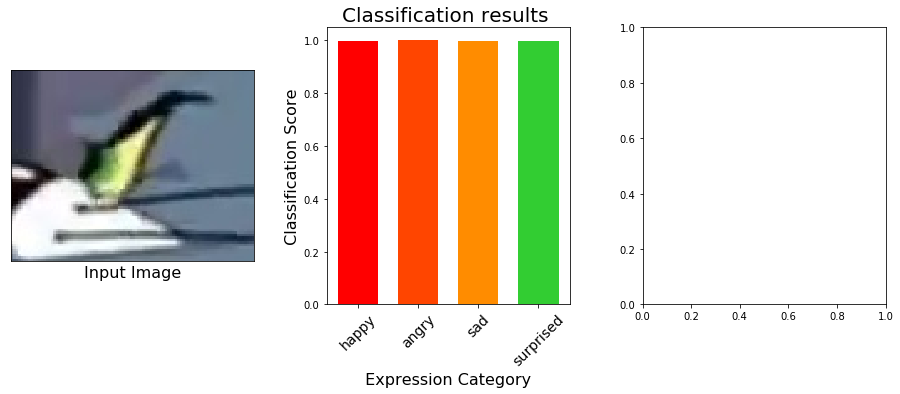

In [6]:
while True:
    # read the next frame from the file
    (grabbed, frame) = vs.read()
    # if the frame was not grabbed, then we have reached the end
    # of the stream
    if not grabbed:
        break
    # if the frame dimensions are empty, grab them
    if W is None or H is None:
        (H, W) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
        swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    layerOutputs = net.forward(ln)
    end = time.time()
    boxes = []
    confidences = []
    classIDs = []
    
    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > 0.5:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)
                
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            # draw a bounding box rectangle and label on the frame       
            color = [int(c) for c in COLORS[classIDs[i]]]
            face_image = frame[y:y+h, x:x+w]
            path = os.path.join(root, 'temp', 'pic.jpg')
            cv2.imwrite(path, face_image)
            emotion = predictor(path)
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]],
                confidences[i])
            text2 = "{}".format(emotion)
            cv2.putText(frame, text, (x, y - 22),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2) 
            cv2.putText(frame, text2, (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2) 
    if writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MP4V")
        writer = cv2.VideoWriter("Train4.mp4", fourcc, 30,
            (frame.shape[1], frame.shape[0]), True)
        # some information on processing single frame
        if total > 0:
            elap = (end - start)
            print("[INFO] single frame took {:.4f} seconds".format(elap))
            print("[INFO] estimated total time to finish: {:.4f}".format(
                elap * total))
    # write the output frame to disk
    writer.write(frame)
# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()